# Food Vision

**Original Paper** -> https://arxiv.org/pdf/1606.05675.pdf

> Trying to beat the `77.4%` in `Top-1 accuracy` column with this notebook.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6cda36e9-46a6-5719-470b-11bc308748d7)


## Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

import os
import random
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Importing helper functions

In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-15 11:04:39--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18407 (18K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  17.98K  --.-KB/s    in 0s      

2022-08-15 11:04:40 (99.0 MB/s) - ‘helper_functions.py’ saved [18407/18407]



In [4]:
from helper_functions import unzip_data, plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix, make_confusion_matrix_for_larger_dataset

## Tensorflow Datasets

**Original Link** -> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

**Food101 Dataset** -> https://www.tensorflow.org/datasets/catalog/food101

## Load the Data

In [5]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=False, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteO5I86J/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteO5I86J/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

## Exploring the Food101 Dataset

In [8]:
class_names= ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
len(train_data)

75750

In [10]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_one_sample= train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        


In [13]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [14]:
image.shape

TensorShape([512, 512, 3])

In [15]:
image/255,

(<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
 array([[[0.9137255 , 0.99215686, 0.9843137 ],
         [0.90588236, 0.99215686, 0.98039216],
         [0.89411765, 0.99607843, 0.9843137 ],
         ...,
         [0.33333334, 0.32156864, 0.34901962],
         [0.26666668, 0.2627451 , 0.29411766],
         [0.22352941, 0.22352941, 0.2627451 ]],
 
        [[0.9098039 , 0.99607843, 0.9882353 ],
         [0.8980392 , 0.99607843, 0.9843137 ],
         [0.8862745 , 1.        , 0.9843137 ],
         ...,
         [0.4745098 , 0.45490196, 0.47058824],
         [0.39215687, 0.3882353 , 0.40784314],
         [0.3372549 , 0.33333334, 0.35686275]],
 
        [[0.89411765, 0.99607843, 0.99215686],
         [0.8862745 , 1.        , 0.99215686],
         [0.8745098 , 1.        , 0.9882353 ],
         ...,
         [0.6431373 , 0.62352943, 0.60784316],
         [0.5686275 , 0.5529412 , 0.5411765 ],
         [0.5019608 , 0.49803922, 0.49019608]],
 
        ...,
 
        [[0.25882354, 0.4392157 

In [16]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

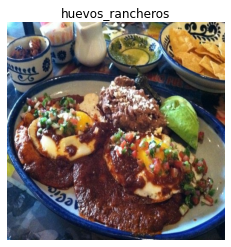

In [17]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

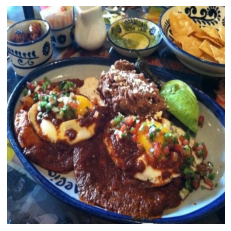

In [18]:
plt.imshow(image)
plt.axis(False);

Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Lab

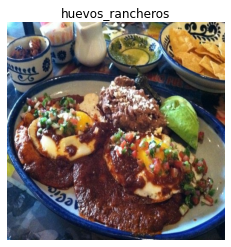

In [19]:
train_one_sample=[]
for i in range(10):
  train_one_sample.append(train_data.take(1))
  for image, label in train_one_sample[i]:
    plt.imshow(image/255)
    plt.title(class_names[label.numpy()])
    plt.axis(False);
    print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
  

In [20]:
train_one_sample= train_data.take(10)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Preprocessing function to preprocess our data

> Neural Network perform best when data is in a certain way(e.g. `batched, normalized, etc`)

> Before we pass, the data to the model for training, we need to do a few thing to the data for it to be eligiable to be passed to the model for training

### what are the problems with the data we have currently:-

* Images are in `uint8` datatype

* Images are of varying sizes

* Images are not scaled(between 0-1)

### What type of data, models like:

* Data needs to be in `float32` dtype(or for `mixed precision` in `float16 and float32`)

* For Batches, Tensorflow likes the images in a `constant/consistent/same size`.

* Normalized/scaled data(values between 0-1) speeds up the traning process and helps the model learn the patterns of the dataset faster

#### Working of the preprocessing function

* Reshaping all of the images to the same size
* Convert all of the dtypes of our image tensors from `uint8` to `float32` which models like.

In [21]:
def preprocess_image(image, label, img_shape=224, scaling=False):
  """
    Converts any image datatype to 'float32', and reshapes the images to [img_shape, img_shape, color_channels]
    Args:
      image: The image to the preprocesses
      label: string, The label of the image
      img_shape: int, Default is '224'. The shape to which the image is preprocessed into.
    Returns:
      (newImage, label) respectively as a tupel

  """
  image= tf.image.resize(image, [img_shape, img_shape]) # Resizing the image into a same size.
  if scaling:
    image= image/255. # Scaling/Normalizing values of the image. EfficientNetBx models have build-in rescaling layers
  newdtypeImage= tf.cast(image, tf.float32) # Changing the dtype of the image into float32
  return newdtypeImage, label

### Trying the preprocessed function

In [22]:
preprocessed_img, preprocessed_label= preprocess_image(image, label)

In [23]:
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[230.65816  , 253.64285  , 251.       ],
        [222.99998  , 254.97449  , 252.19388  ],
        [207.06633  , 255.       , 250.36734  ],
        ...,
        [140.66287  , 129.52519  , 121.22428  ],
        [121.14268  , 115.265144 , 116.95397  ],
        [ 83.95363  ,  83.08119  ,  89.63737  ]],

       [[221.47449  , 254.37755  , 253.33163  ],
        [214.5102   , 255.       , 253.92348  ],
        [198.41327  , 254.58673  , 251.96939  ],
        ...,
        [208.66318  , 195.82143  , 173.40823  ],
        [197.03056  , 190.1071   , 174.83162  ],
        [175.54036  , 171.6169   , 161.21384  ]],

       [[204.21428  , 253.42857  , 249.57143  ],
        [198.71428  , 254.64287  , 251.2449   ],
        [185.04591  , 251.73979  , 252.21428  ],
        ...,
        [222.45403  , 207.47444  , 169.35715  ],
        [216.52551  , 205.01024  , 172.02556  ],
        [215.51529  , 207.87244  , 177.58672  ]],

       ...,

     

In [24]:
preprocessed_img_1, preprocessed_label_1= preprocess_image(image, label, scaling=False)

In [25]:
preprocessed_img_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[230.65816  , 253.64285  , 251.       ],
        [222.99998  , 254.97449  , 252.19388  ],
        [207.06633  , 255.       , 250.36734  ],
        ...,
        [140.66287  , 129.52519  , 121.22428  ],
        [121.14268  , 115.265144 , 116.95397  ],
        [ 83.95363  ,  83.08119  ,  89.63737  ]],

       [[221.47449  , 254.37755  , 253.33163  ],
        [214.5102   , 255.       , 253.92348  ],
        [198.41327  , 254.58673  , 251.96939  ],
        ...,
        [208.66318  , 195.82143  , 173.40823  ],
        [197.03056  , 190.1071   , 174.83162  ],
        [175.54036  , 171.6169   , 161.21384  ]],

       [[204.21428  , 253.42857  , 249.57143  ],
        [198.71428  , 254.64287  , 251.2449   ],
        [185.04591  , 251.73979  , 252.21428  ],
        ...,
        [222.45403  , 207.47444  , 169.35715  ],
        [216.52551  , 205.01024  , 172.02556  ],
        [215.51529  , 207.87244  , 177.58672  ]],

       ...,

     

original Image
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros


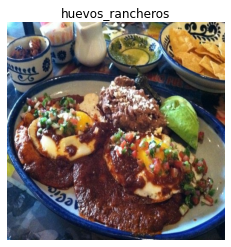

In [26]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros


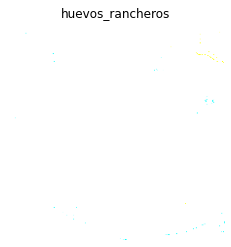

In [27]:
print("Preprocessed Image")
plt.imshow(preprocessed_img)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img.shape} Image dtype: {preprocessed_img.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

Preprocessed Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 56
    Class name (str form): huevos_rancheros


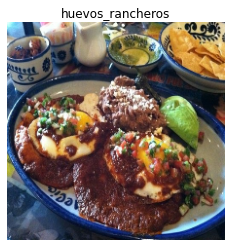

In [28]:
print("Preprocessed Image")
plt.imshow(preprocessed_img_1/255)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {preprocessed_img_1.shape} Image dtype: {preprocessed_img_1.dtype} Target class or Label from Food101 (tensor form): {preprocessed_label_1}
    Class name (str form): {class_names[preprocessed_label_1.numpy()]}""")
plt.axis(False);

## Creating batches of the dataset and preparing the datasets

**Resources** -> https://www.tensorflow.org/guide/data_performance

In [29]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Explanation

> Now, when the dataset is download using tensorflow dataset(`tfds`), it will not be `shuffled` as `shuffle_files` is set to `False`. Now When preprocessing the dataset, I am only shuffeling the `train_data` dataset. Otherwise if I shuffle `test_data` as well, It is causing problems when I am trying to `evaluate the trained model`. The `predicted values` of the model are not in the correct order/shuffled with the `truth values` from the `test_data` that's why. 

In [30]:
# Mapped the preprocessing function to training data
train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Tensorflow is going to automatically, tune the number of process the function uses.

# Shuffle train_data and turn it into batches and prefetch it(loading the data faster)
train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # It is going to shuffle 1000 sampples at a time

# Mapped the preprocessing function to test data
test_data= test_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

## Explanation

"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batc

In [31]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create Modelling callbacks

In [33]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [34]:
# Model Checkpoint Callback
checkpoint_feature_extraction= 'checkpoints/feature_extraction_model'
checkpoint_callback=model_check_point_callback(checkpoint_feature_extraction, save_weights_only=True, save_best_only=True, monitor="val_loss")

# Tensorboard Callback
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")

# Early Stopping Callback
early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=5)

# Learning Rate Scheduler

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Reduce Learing Rate Callback

learning_rate_reduce_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220815-111448


## Mixed Precision Training

> Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

**Guide** -> https://www.tensorflow.org/guide/mixed_precision

## Adding Augmented Layer

In [35]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turnining on Mixed Precision Training


In [36]:
mixed_precision.set_global_policy("mixed_float16")

In [37]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [38]:
len(class_names)

101

In [39]:
CLASS_COUNT=len(class_names)

## Build Feature extraction model

> We will be using `Augmented, Dropout, Regularization` layers to reduce `overfitting` of the model. We will be using `Learning rate Scheduler` as well.

> Try once with `Learning Rate Scheduler` and use `learning rate callback` instead

In [40]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x= augmented_layer(inputs)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=  tf.keras.layers.Dropout(0.2, name="dropout_layer")(x) # Dropout Layer
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), name='regularization_layer')(x) # Regularization Layer
x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

## Checking the layers of the model

* `layer.name` -> Human readable name of the layer
* `layer.trainable` -> Boolean, layer is trainable or not, if the layers are frozen or unfrozen
* `layer.dtype` -> The dtype format in which the layer stores the variables in

* `layer.dtype_policy` -> The dype_policy in which the layer computes the variables in

## Checking the dtype_policy of the layer of the base_model

In [42]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f2b176c6b50> input_1 float32 <Policy "float32">
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2b17a96ed0> rescaling float32 <Policy "mixed_float16">
<keras.layers.preprocessing.normalization.Normalization object at 0x7f2b17489bd0> normalization float32 <Policy "mixed_float16">
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2b17abe650> stem_conv_pad float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7f2b174b0250> stem_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2b17aaedd0> stem_bn float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7f2b17484d50> stem_activation float32 <Policy "mixed_float16">
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2b146decd0> block1a_dwconv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormal

In [43]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout_layer True float32 <Policy "mixed_float16">
regularization_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Training the feature_extraction layer

In [44]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler_callback, learning_rate_reduce_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9951 - accuracy: 0.5219
Epoch 1: val_loss improved from inf to 1.38183, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 188s 71ms/step - loss: 1.9951 - accuracy: 0.5219 - val_loss: 1.3818 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 2/10
2367/2368 [============================>.] - ETA: 0s - loss: 1.6106 - accuracy: 0.6131
Epoch 2: val_loss improved from 1.38183 to 1.32227, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 169s 71ms/step - loss: 1.6106 - accuracy: 0.6132 - val_loss: 1.3223 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.5446 - accuracy: 0.6321
Epoch 3: val_loss improved from 1.32227 to 1.30391, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 169s 71ms/step - loss: 1.5446 - accuracy: 0.6321 - v

In [45]:
model.evaluate(test_data)

790/790 [==============================] - 49s 61ms/step - loss: 1.2060 - accuracy: 0.7189


[1.2059522867202759, 0.7188910841941833]

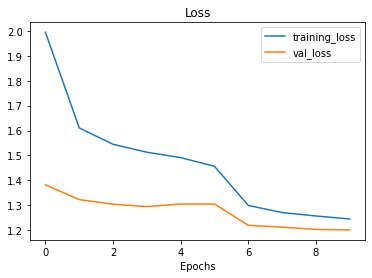

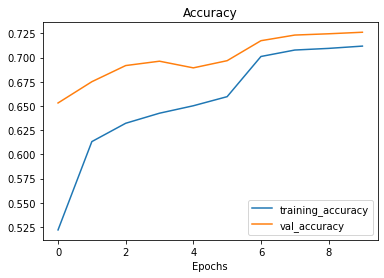

In [46]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [47]:
result_feature_extraction= model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 49s 61ms/step - loss: 1.2060 - accuracy: 0.7189


[1.2059522867202759, 0.7188910841941833]

## Saving the model

In [48]:
saved_model_dir='saved_models/model_feature_extraction_model'

In [49]:
model.save(saved_model_dir)

## Downloading the saved models

In [50]:
!zip -r saved_model_dir


zip error: Nothing to do! (saved_model_dir.zip)


## Downloading the saved model from Colab

In [51]:
# from google.colab import files
# files.download('/content/saved_models.zip')

FileNotFoundError: ignored

## Loading and Evaluating the Checkpoint Weights

* tf.keras.models.clone_model()
* load_weights()
* evaluate()

### Trying to Clone the Feature Extracted Model with `clone_model()`

In [52]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [54]:
checkpoint_feature_extraction

'checkpoints/feature_extraction_model'

In [55]:
cloned_model.load_weights(checkpoint_feature_extraction)

## We have to recompile the model each time we make some changes to the original model

In [56]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [57]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)
results_cloned_model_with_loaded_weights

790/790 [==============================] - 52s 62ms/step - loss: 1.8132 - accuracy: 0.5676


[1.8132206201553345, 0.5675643682479858]

In [58]:
results_cloned_model_with_loaded_weights == result_feature_extraction

False

In [59]:



np.allclose(results_cloned_model_with_loaded_weights, result_feature_extraction)

False

## Load the saved Feature Extraction Model

In [60]:
loaded_model= tf.keras.models.load_model(saved_model_dir)

In [61]:
loaded_model_result=loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 51s 63ms/step - loss: 1.2060 - accuracy: 0.7189


[1.2059522867202759, 0.7188910841941833]

In [62]:
result_feature_extraction

[1.2059522867202759, 0.7188910841941833]

## Checking if the model saved/loaded correctly

In [63]:
loaded_model_result == result_feature_extraction

True

In [64]:
np.allclose(result_feature_extraction,loaded_model_result)

True

## Checking the layers of the loaded model

In [65]:
for layer in loaded_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2a7dc50110> input_layer True
<keras.engine.functional.Functional object at 0x7f2a7dcbb950> efficientnetb0 False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2a7d0bf790> pooling_layer True
<keras.layers.core.dropout.Dropout object at 0x7f2a7d083710> dropout_layer True
<keras.layers.core.dense.Dense object at 0x7f2a7d0bfc10> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7f2a7d1ac610> dense True
<keras.layers.core.activation.Activation object at 0x7f2a7d182250> softmax_float32 True


## Checking the dtype_policy of the loaded model

In [66]:
for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

## Unfreezing all the layers of the base_model i.e EfficientNetB0 for Fine-Tuning

In [67]:
for layer in loaded_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

input_layer float32 <Policy "float32"> True
efficientnetb0 float32 <Policy "mixed_float16"> True
pooling_layer float32 <Policy "mixed_float16"> True
dropout_layer float32 <Policy "mixed_float16"> True
regularization_layer float32 <Policy "mixed_float16"> True
dense float32 <Policy "mixed_float16"> True
softmax_float32 float32 <Policy "float32"> True


In [68]:
for layer in loaded_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2a7d230390> input_1 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f2a7c8b4090> rescaling True
<keras.layers.preprocessing.normalization.Normalization object at 0x7f2a7c8b4350> normalization True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2a7d298150> stem_conv_pad True
<keras.layers.convolutional.Conv2D object at 0x7f2a7d286990> stem_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2a7d3d4610> stem_bn True
<keras.layers.core.activation.Activation object at 0x7f2a7d4a9810> stem_activation True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f2a7d4b2f50> block1a_dwconv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2a7d55c510> block1a_bn True
<keras.layers.core.activation.Activation object at 0x7f2a7d528850> block1a_activation True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2a7d5ad550> block1

In [69]:
for layer in loaded_model.layers[1].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [70]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

In [71]:
len(loaded_model.layers)

7

In [72]:
len(loaded_model.trainable_variables)

215

In [73]:
len(base_model.trainable_variables)

0

In [74]:
len(base_model.layers)

237

## Callback for Fine-Tuning All unfrozen layers

In [75]:
checpoint_fine_tuning= "checkpoints_fine_tuning_all"

checkpoint_callback_fine_tuning_all_unfrozen=model_check_point_callback(checpoint_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback_fine_tuning_all_unfrozen= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all_unfrozen= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback_all_unfrozen= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_fine_tuning_all_data_all_unfrozen_layers/20220815-115155


## Recompiling the model before Fine-Tuning

In [76]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

## Fine-Tuning for all unfrozen layers

In [77]:
history_fine_tuned_all= loaded_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning_all_unfrozen, tensorboard_callback_fine_tuning_all_unfrozen, early_stopping_callback_fine_tuning_all_unfrozen, learning_rate_reduce_callback_all_unfrozen])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.1768 - accuracy: 0.7271
Epoch 1: val_accuracy improved from -inf to 0.78257, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 356s 142ms/step - loss: 1.1768 - accuracy: 0.7271 - val_loss: 0.9506 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8611 - accuracy: 0.8057
Epoch 2: val_accuracy improved from 0.78257 to 0.80138, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 336s 141ms/step - loss: 0.8611 - accuracy: 0.8057 - val_loss: 0.8929 - val_accuracy: 0.8014 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.8634
Epoch 3: val_accuracy improved from 0.80138 to 0.80482, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 333s 140ms/step - loss: 0.6410 - accuracy: 0.8634 - v

In [78]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [79]:
result_loaded_model_2=loaded_model.evaluate(test_data)
result_loaded_model_2

790/790 [==============================] - 49s 61ms/step - loss: 0.9738 - accuracy: 0.8172


[0.9738017320632935, 0.8171881437301636]

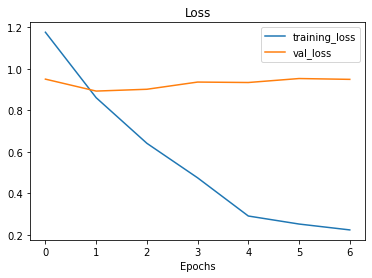

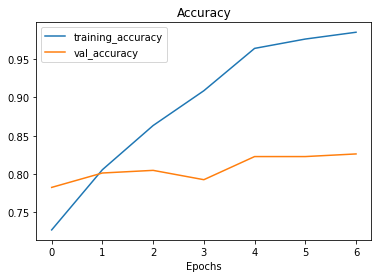

In [80]:
plot_loss_curves(history_fine_tuned_all)

## Viewing/Comparing results on tensorboard


Link -> https://tensorboard.dev/experiment/8RDC0W82QkCB22MQyuYhag/#scalars

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning on the Food101 dataset" \
--description "Training a Transfer Learning model with EfficientNetB0 to beat the DeepFood paper which is based on the Food101 dataset." \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

In [ ]:
!tensorboard dev list

## Evaluating `loaded_model`

In [81]:
pred_probs=loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 50s 62ms/step


In [82]:
len(pred_probs)

25250

In [83]:
pred_probs.shape

(25250, 101)

In [84]:
pred_probs[1]

array([1.28436255e-11, 6.62326856e-13, 1.10935428e-11, 8.55825355e-10,
       2.51626359e-10, 2.77762882e-12, 2.04440388e-11, 7.35609296e-10,
       5.72248464e-11, 2.92847344e-11, 3.17882769e-11, 1.38014572e-10,
       1.34423084e-10, 9.59272245e-11, 3.43713218e-11, 8.41734626e-10,
       1.51039597e-11, 3.20375948e-11, 8.80075186e-06, 4.97178097e-11,
       1.38061368e-11, 9.00138818e-12, 2.36265674e-10, 1.32513263e-11,
       5.71473038e-07, 1.15806080e-11, 7.82669762e-10, 2.02286216e-10,
       9.94418783e-12, 3.34342336e-13, 4.90280613e-13, 2.45567428e-13,
       2.52525556e-09, 6.43300213e-12, 9.25091687e-12, 2.29254504e-09,
       1.20790614e-10, 1.02644453e-08, 3.50387742e-13, 1.35981812e-08,
       4.44665192e-13, 1.77726974e-07, 2.79983189e-11, 3.06302553e-11,
       1.61143265e-09, 4.18728441e-10, 2.37618623e-11, 6.47370513e-09,
       1.31205897e-12, 1.42904488e-09, 3.14934603e-08, 1.30497779e-09,
       3.87318355e-09, 3.32438634e-12, 1.69232113e-08, 2.62428290e-13,
      

In [85]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

array([29, 81, 91, 53, 97])

In [86]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [87]:
len(pred_classes)

25250

In [88]:
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [89]:
len(y_labels)

25250

## Accuracy Score

In [90]:
sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

0.8171881188118811

## Confusion Matrix

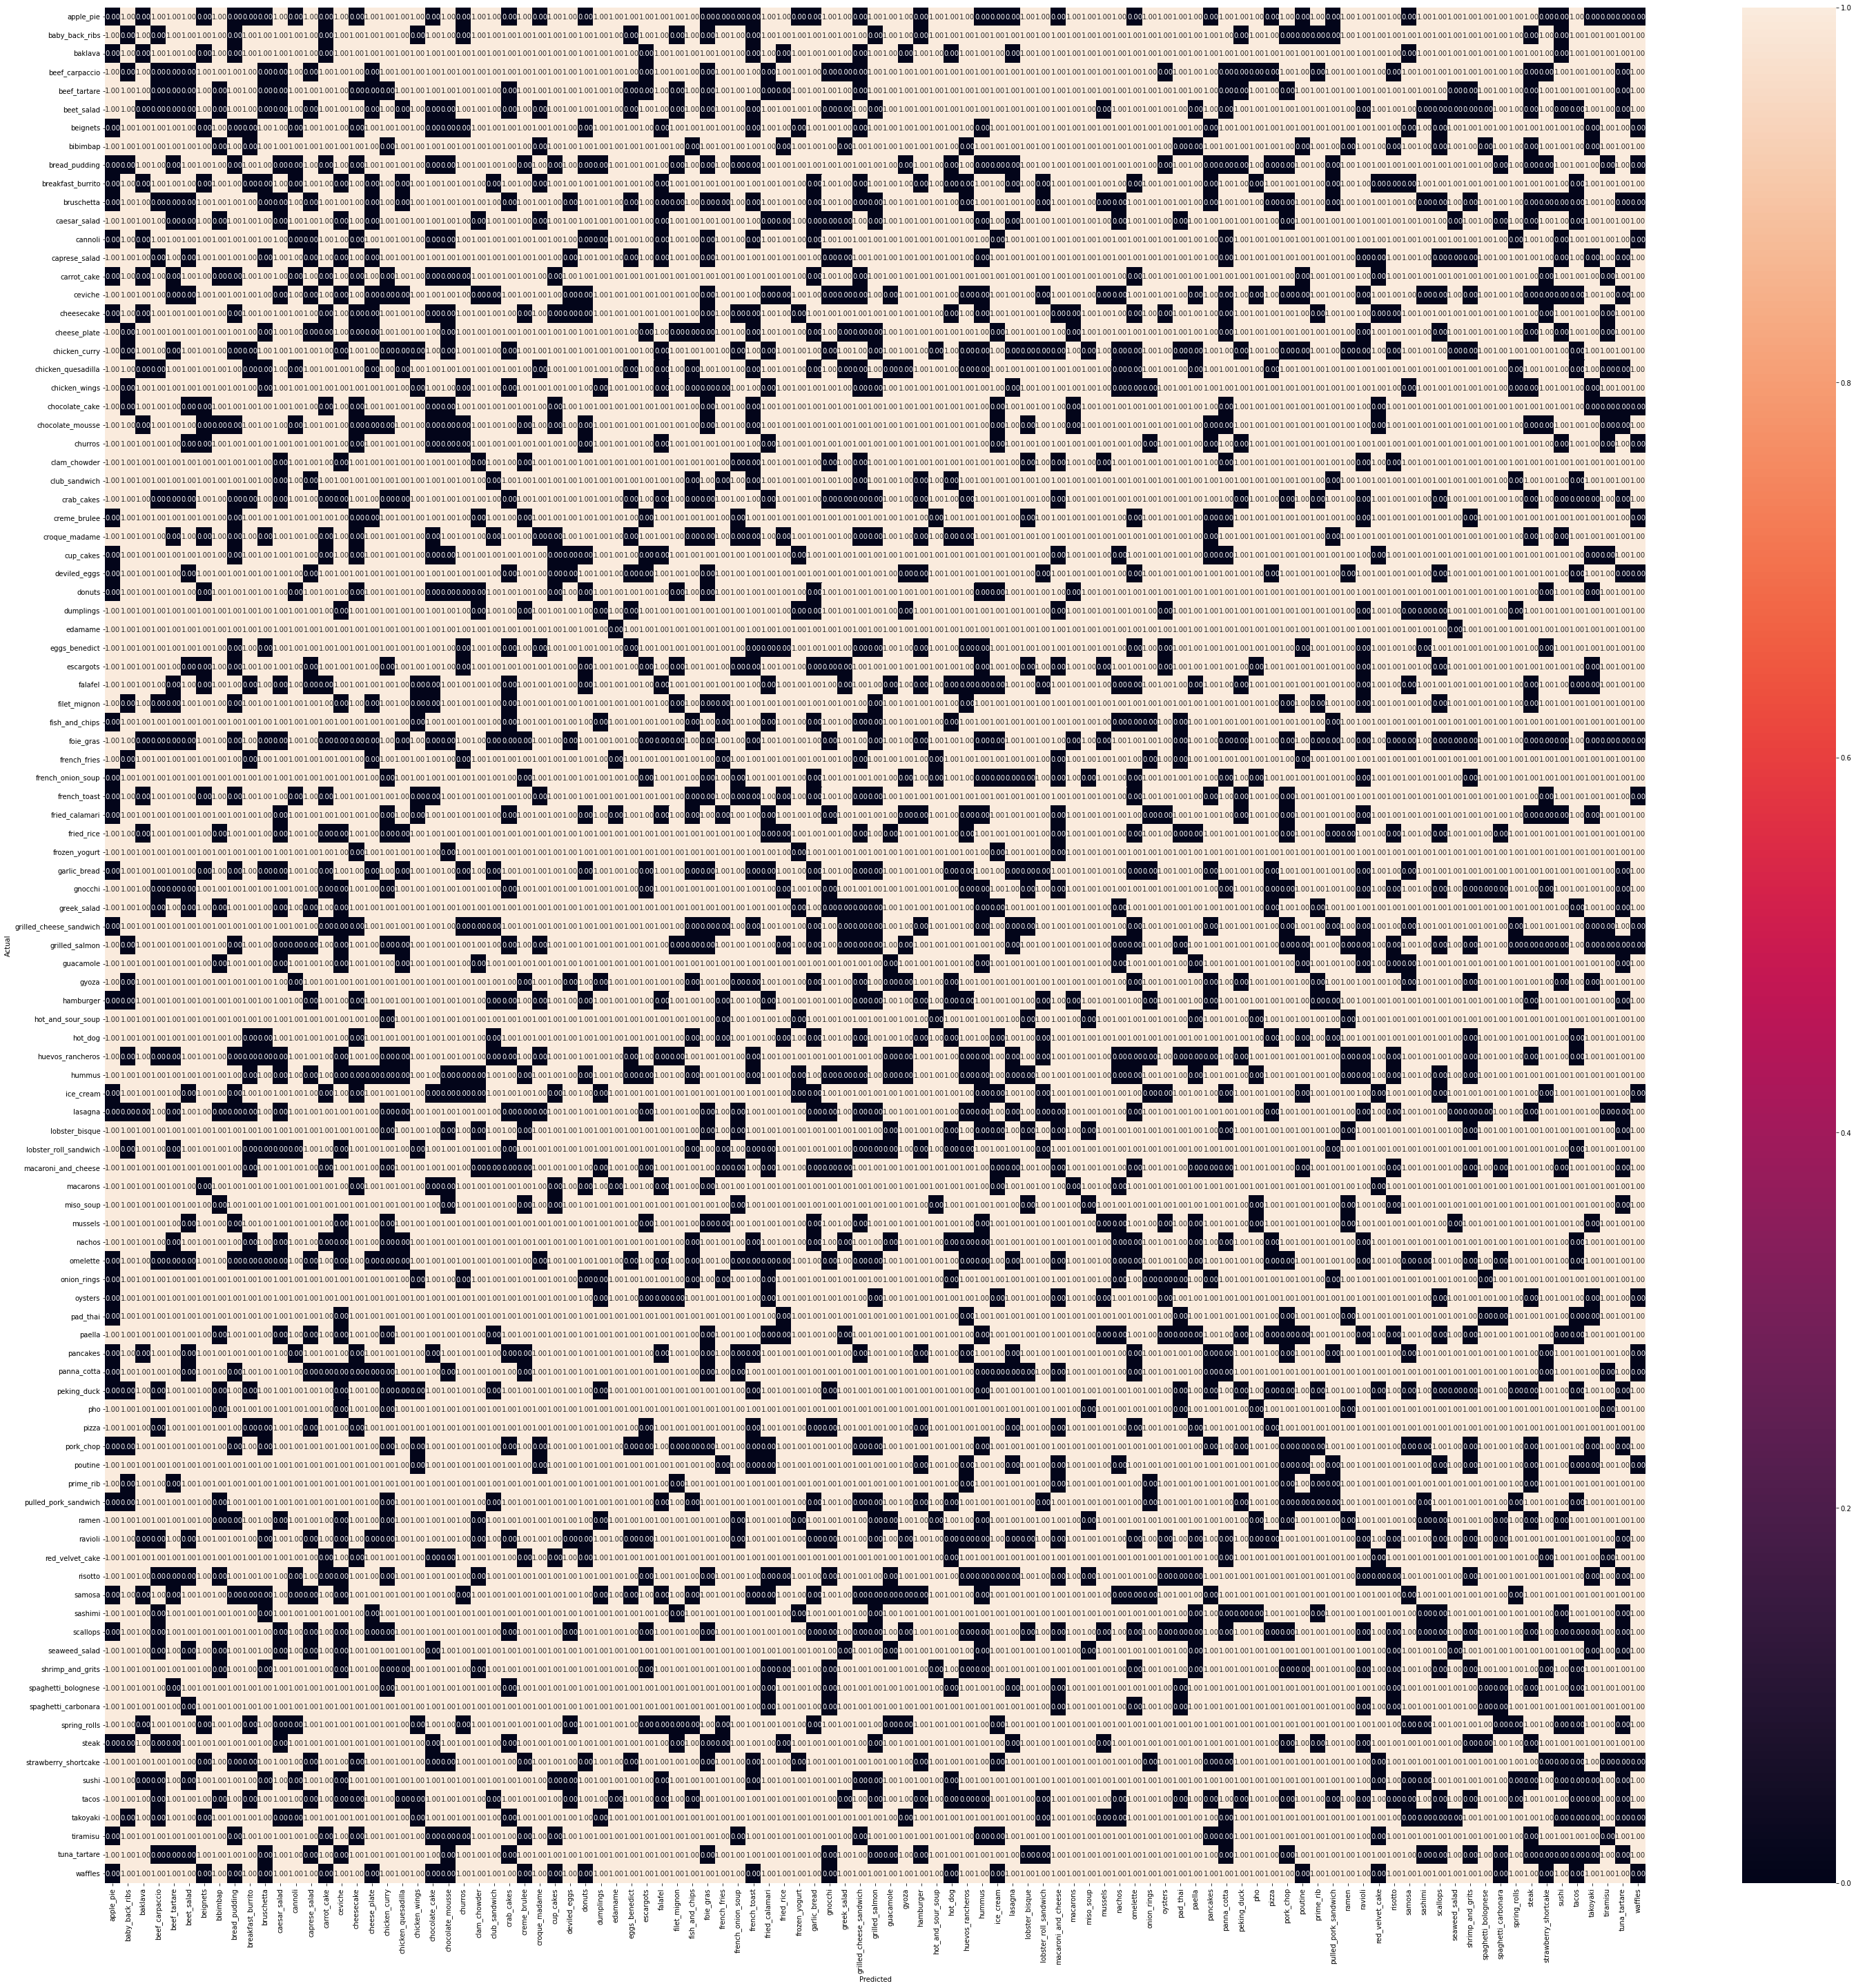

In [91]:
cm = confusion_matrix(y_labels, pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]==0
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

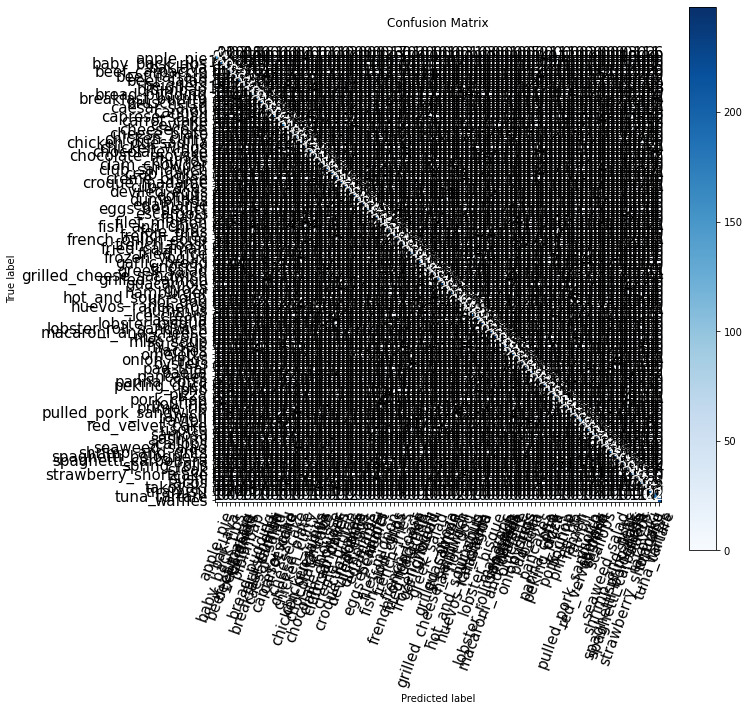

In [92]:
make_confusion_matrix_for_larger_dataset(y_labels, pred_classes, class_names)

## Classification Report 

In [93]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62       250
           1       0.83      0.78      0.80       250
           2       0.86      0.89      0.88       250
           3       0.81      0.83      0.82       250
           4       0.76      0.79      0.77       250
           5       0.73      0.69      0.71       250
           6       0.84      0.88      0.86       250
           7       0.90      0.93      0.92       250
           8       0.68      0.65      0.67       250
           9       0.79      0.73      0.76       250
          10       0.78      0.73      0.76       250
          11       0.81      0.87      0.84       250
          12       0.89      0.90      0.89       250
          13       0.80      0.83      0.81       250
          14       0.80      0.81      0.80       250
          15       0.72      0.67      0.69       250
          16       0.67      0.70      0.68       250
          17       0.88    

In [94]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.6226012793176973,
  'precision': 0.6666666666666666,
  'recall': 0.584,
  'support': 250},
 '1': {'f1-score': 0.8033126293995859,
  'precision': 0.8326180257510729,
  'recall': 0.776,
  'support': 250},
 '10': {'f1-score': 0.7551867219917011,
  'precision': 0.7844827586206896,
  'recall': 0.728,
  'support': 250},
 '100': {'f1-score': 0.8752475247524752,
  'precision': 0.8666666666666667,
  'recall': 0.884,
  'support': 250},
 '11': {'f1-score': 0.836223506743738,
  'precision': 0.8066914498141264,
  'recall': 0.868,
  'support': 250},
 '12': {'f1-score': 0.8906560636182902,
  'precision': 0.8853754940711462,
  'recall': 0.896,
  'support': 250},
 '13': {'f1-score': 0.8149606299212598,
  'precision': 0.8023255813953488,
  'recall': 0.828,
  'support': 250},
 '14': {'f1-score': 0.804780876494024,
  'precision': 0.8015873015873016,
  'recall': 0.808,
  'support': 250},
 '15': {'f1-score': 0.6943866943866944,
  'precision': 0.7229437229437229,
  'recall': 0.668,
  'su

## Visualizing the F1-score

In [95]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

{'apple_pie': 0.6226012793176973,
 'baby_back_ribs': 0.8033126293995859,
 'baklava': 0.8757396449704142,
 'beef_carpaccio': 0.8181818181818182,
 'beef_tartare': 0.7740667976424361,
 'beet_salad': 0.7119341563786008,
 'beignets': 0.8610567514677105,
 'bibimbap': 0.9151873767258383,
 'bread_pudding': 0.6653061224489796,
 'breakfast_burrito': 0.7583333333333333,
 'bruschetta': 0.7551867219917011,
 'caesar_salad': 0.836223506743738,
 'cannoli': 0.8906560636182902,
 'caprese_salad': 0.8149606299212598,
 'carrot_cake': 0.804780876494024,
 'ceviche': 0.6943866943866944,
 'cheese_plate': 0.8686868686868686,
 'cheesecake': 0.684931506849315,
 'chicken_curry': 0.7425149700598802,
 'chicken_quesadilla': 0.8041237113402062,
 'chicken_wings': 0.889763779527559,
 'chocolate_cake': 0.691358024691358,
 'chocolate_mousse': 0.6373626373626373,
 'churros': 0.9028340080971659,
 'clam_chowder': 0.874251497005988,
 'club_sandwich': 0.8692152917505029,
 'crab_cakes': 0.7345309381237526,
 'creme_brulee': 0.88

In [96]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

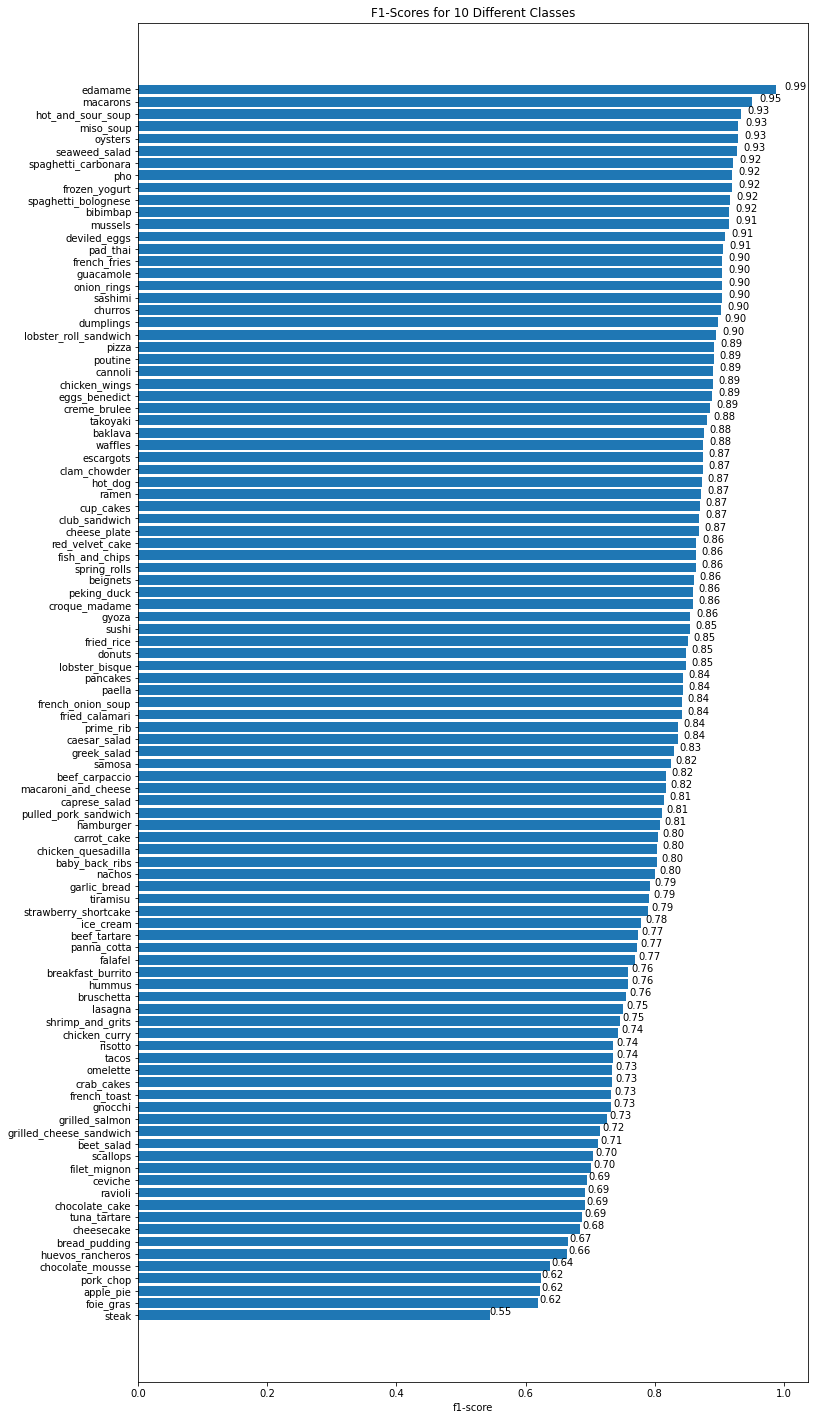

In [97]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Evaluating on custom dataset

In [101]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-08-15 12:54:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.08s   

2022-08-15 12:54:21 (156 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [102]:
unzip_data('custom_food_images.zip')

In [103]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg']

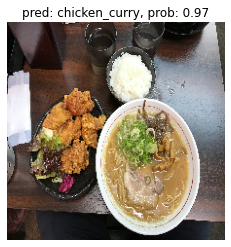

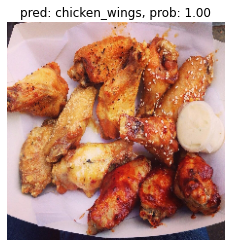

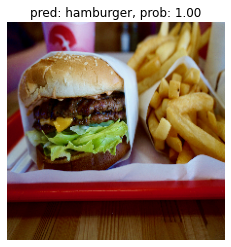

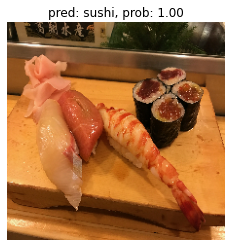

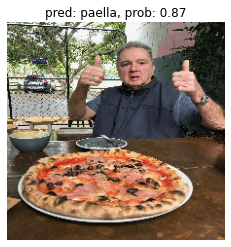

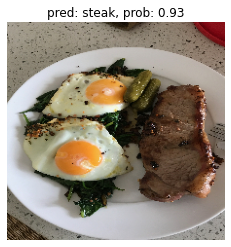

In [104]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)